# Churn prediction problem  
![churn rate](https://fia.com.br/wp-content/uploads/2022/06/cr.jpg)  
Font: https://www.fia.com.br

### **About Dataset**    
"Predict behavior to retain customers. You can analyze all relevant customer data and develop focused customer retention programs." [IBM Sample Data Sets]
<br></br>
### **Content**  
Each row represents a customer, each column contains customer’s attributes described on the column Metadata.

The data set includes information about:

Customers who left within the last month – the column is called Churn
Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies
Customer account information – how long they’ve been a customer, contract, payment method, paperless billing, monthly charges, and total charges
Demographic info about customers – gender, age range, and if they have partners and dependents

data link: https://www.kaggle.com/datasets/blastchar/telco-customer-churn  
<br></br>
### **My Goals**
- Extract valuable insights from Telco Customer Churn Data that could explain the churn likelihood.
- Create a Machine Learning model to predict the churn probability for a given client with the least sufficient number of features as possible.
- Build a Streamlit web app to deliver the model to the final user.
- Containerize data product by creating a Docker image and uploading it to Docker Hub.
- Deploy on a large scalable architechture leveraging Docker with Kubernetes on Google Kubernetes Engine (GKE).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_selector as selector
from sklearn.cluster import KMeans
from sklearn import metrics as ms

import statsmodels.formula.api as smf
import matplotlib as mpl

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
plt.style.use('seaborn-white')

In [2]:
# loading and separating test set
data = pd.read_csv('data.csv').drop('customerID', 1)
train, test = data.iloc[:int(data.shape[0]*.7), :], data.iloc[int(data.shape[0]*.7):, :]
train.head(5)

<ipython-input-2-2b984f087fae>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data = pd.read_csv('data.csv').drop('customerID', 1)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# 1) Exploratory Data Analysis

In [3]:
train.shape

(4930, 20)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4930 entries, 0 to 4929
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            4930 non-null   object 
 1   SeniorCitizen     4930 non-null   int64  
 2   Partner           4930 non-null   object 
 3   Dependents        4930 non-null   object 
 4   tenure            4930 non-null   int64  
 5   PhoneService      4930 non-null   object 
 6   MultipleLines     4930 non-null   object 
 7   InternetService   4930 non-null   object 
 8   OnlineSecurity    4930 non-null   object 
 9   OnlineBackup      4930 non-null   object 
 10  DeviceProtection  4930 non-null   object 
 11  TechSupport       4930 non-null   object 
 12  StreamingTV       4930 non-null   object 
 13  StreamingMovies   4930 non-null   object 
 14  Contract          4930 non-null   object 
 15  PaperlessBilling  4930 non-null   object 
 16  PaymentMethod     4930 non-null   object 


In [5]:
def handle_strnumber(point):
  if type(point) == str:
    try:
      point = float(point)
      return point
    except:
      return 'dropme'

In [6]:
train['TotalCharges'] = train['TotalCharges'].apply(lambda x: handle_strnumber(x))
train = train[train['TotalCharges'] != 'dropme']
train['TotalCharges'] = train['TotalCharges'].astype(float)

<ipython-input-6-3a1b80f7433a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['TotalCharges'] = train['TotalCharges'].apply(lambda x: handle_strnumber(x))
<ipython-input-6-3a1b80f7433a>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['TotalCharges'] = train['TotalCharges'].astype(float)


In [ ]:
train.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,4922.000000,4922.000000,4922.000000,4922.000000
mean,0.159488,32.389679,64.898151,2282.250772
std,0.366168,24.619406,30.132816,2270.485234
min,0.000000,1.000000,18.250000,18.800000
25%,0.000000,9.000000,35.612500,392.537500
50%,0.000000,29.000000,70.500000,1401.700000
75%,0.000000,56.000000,89.987500,3775.050000
max,1.000000,72.000000,118.750000,8684.800000


In [ ]:
np.round(train.Churn.value_counts(normalize = True)*100,2) # data imbalance

No     73.81
Yes    26.19
Name: Churn, dtype: float64

Data presents target imbalance. This points in favor of stratifying data and dealing with class weights on the modelling stage.

In [ ]:
# separating columns
INT_COLS = [col for col in train.columns if train[col].dtype != object]
CAT_COLS = [col for col in train.columns if col not in INT_COLS and col != 'Churn']
TARGET = ['Churn']

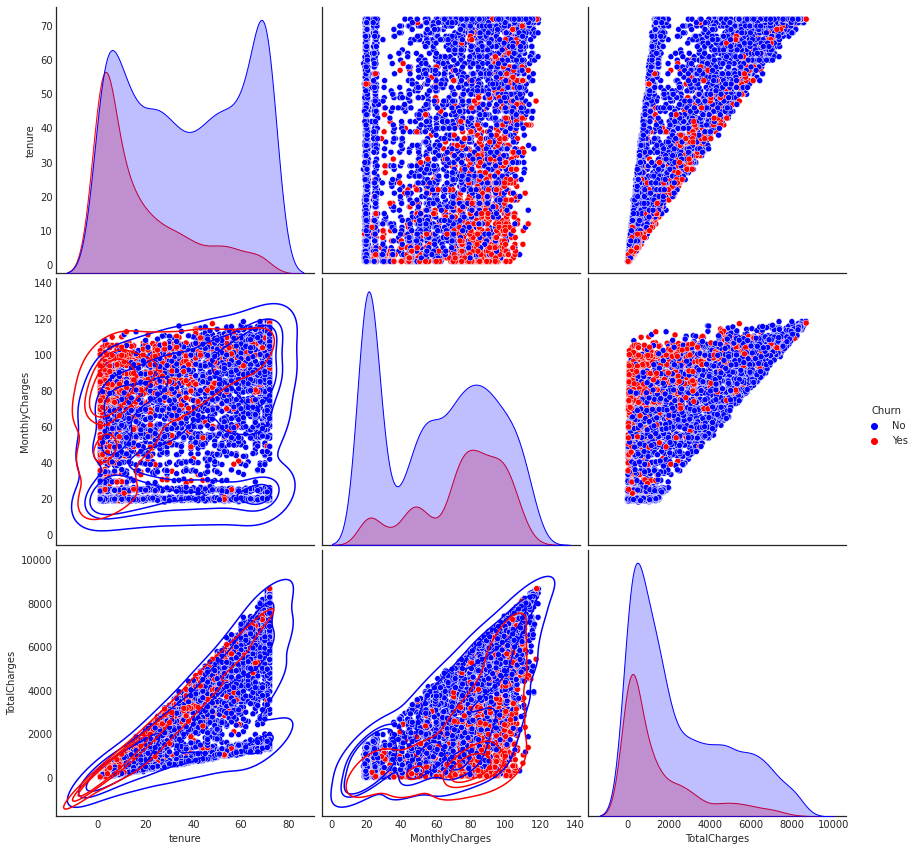

In [ ]:
sns.set_style("white");
x_vars = ['tenure', 'MonthlyCharges', 'TotalCharges']
y_vars = ['tenure', 'MonthlyCharges','TotalCharges']

g_1 = sns.pairplot(train, hue="Churn", height=4, palette=["blue","red"], x_vars=x_vars,
    y_vars=y_vars);
g_1.map_lower(sns.kdeplot, levels=4, color=".2")
plt.show();

Tenure distribution are much lower-concentrate for the Churn clients when compared to the other spectrum of the problem. 

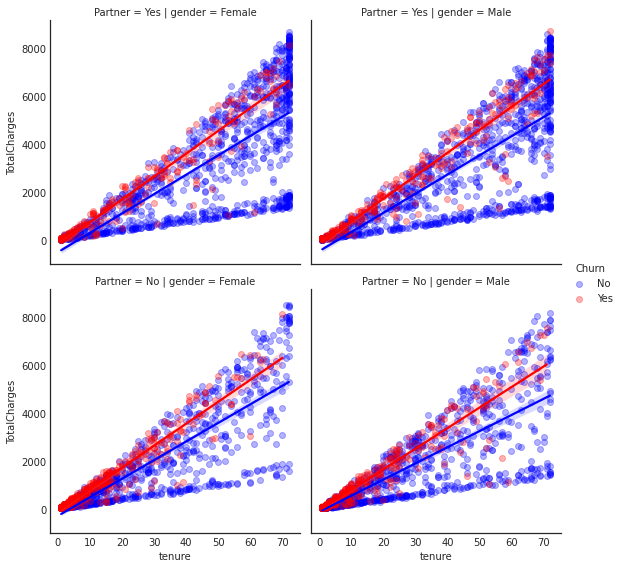

In [ ]:
sns.lmplot(data=train, x=INT_COLS[1], y=INT_COLS[3], hue = 'Churn', markers = ['o','o'],
           col = 'gender', row = 'Partner', height = 4, palette = ['blue', 'red'],
           scatter_kws={'alpha':.3});

The lmplot angular coefficient for the gender differences does not vary considerably. Otherwise, as can be seen on the figure above, at least in this sample, not having a partner seems to be more related to Churn.  

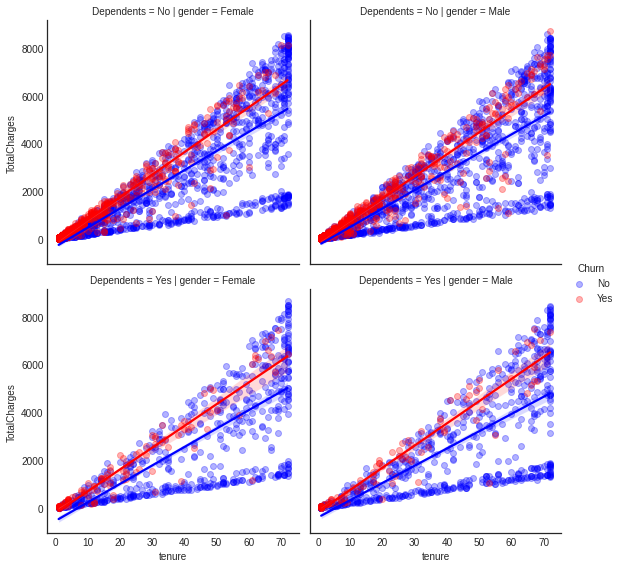

In [ ]:
sns.lmplot(data=train, x=INT_COLS[1], y=INT_COLS[3], hue = 'Churn', markers = ['o','o'],
           col = 'gender', row = 'Dependents', height = 4, palette = ['blue', 'red'],
           scatter_kws={'alpha':.3});

The same idea cannot be painted when the feature being analysed is having or not Dependents. Of course, one can rightly arguee that this observations are not statistically based. That's all fine, as one knows that visualizing data is an important step on Exploratory Data Analysis.

In [7]:
train.groupby('Churn')[['TotalCharges','tenure']].mean()

,TotalCharges,tenure
Churn,,
No,2554.108244,37.57308
Yes,1516.030295,17.78045


In [8]:
pd.crosstab(train['gender'], train['Churn'], normalize=True)

Churn,No,Yes
gender,,
Female,0.361032,0.132060
Male,0.377082,0.129825


#### Wrapping up:  
- No statistically significant gender differences between Churn are observable  
- Not having a Partner seems to be related to greater churn on this sample  
- The mean tenure is much lower for the churn group than no churn group
- Churn group has a lower mean TotalCharge than no churn group

It turns out that the KMeans Clustering algorithm commonly used for unsupervised problems can also be used for Exploratory Data Analysis and even for supervised classification tasks. In this context, creativity suggests me that it can improve our feature knowledge in this sample. Let's examine this

In [ ]:
# features to use
FEATS = ['gender','Partner','Dependents','TechSupport','Contract','PaperlessBilling','PaymentMethod',
         'SeniorCitizen','tenure','TotalCharges']

# KMEANS CLUSTERING FOR EDA
kmeans = KMeans(n_clusters = 2, max_iter = 2000, random_state = 77)

# StandardScaler and PCA for dimensionality reduction
scaler = StandardScaler()
pca = PCA(n_components = 2)
ohe = OneHotEncoder()
wranglers = [scaler, ohe, pca]

preprocessor = ColumnTransformer(transformers=[
    ('scaler', wranglers[0], selector(dtype_exclude=object)),
    ('ohe', wranglers[1], selector(dtype_include=object))])

pipe = Pipeline(steps = [('preprocessor', preprocessor),
                         ('PCA', wranglers[2])])
# kmeans 
train_sc = pd.DataFrame(pipe.fit_transform(train[FEATS].copy()), columns = ['PC1','PC2'])
labels = kmeans.fit_predict(train_sc)
train_sc['cluster'] = labels
train_sc['Churn'] = train['Churn'].map({'Yes':1,'No':0}).copy()

In [ ]:
train_sc.groupby('cluster')['Churn'].mean()

cluster
0    0.274243
1    0.243544
Name: Churn, dtype: float64

There are no big differences in mean Churn per cluster. However, Churn event can be more prevalent in a specific cluster. This idea is analogous to sensitivity and precision. Remember Bayes is already alive!

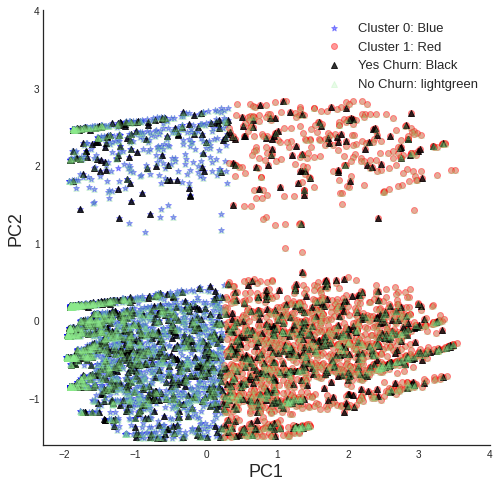

In [ ]:
plt.figure(figsize=[8,8])
plt.scatter(train_sc[train_sc['cluster'] == 0]['PC1'], train_sc[train_sc['cluster'] == 0]['PC2'],
           color = 'blue', marker = '*', alpha = .4, label = 'Cluster 0: Blue')
plt.scatter(train_sc[train_sc['cluster'] == 1]['PC1'], train_sc[train_sc['cluster'] == 1]['PC2'],
           color = 'red', marker = 'o',alpha=.4, label = 'Cluster 1: Red')
plt.scatter(train_sc[train_sc['Churn'] == 1]['PC1'], train_sc[train_sc['Churn'] == 1]['PC2'],
           color = 'black', marker = '^',alpha=.8, label = 'Yes Churn: Black')
plt.scatter(train_sc[train_sc['Churn'] == 0]['PC1'], train_sc[train_sc['Churn'] == 0]['PC2'],
           color = 'lightgreen', marker = '^',alpha=.2, label = 'No Churn: lightgreen')
plt.xlabel('PC1',size=18)
plt.ylabel('PC2',size=18)
plt.xlim([-2.3, 4])
plt.ylim([-1.61, 4])
plt.legend(fontsize=13);

In [ ]:
# precision of churn detection with KMeans Clustering
positive_rights = train_sc[(train_sc['cluster'] == 1) & (train_sc['Churn'] == 1)].shape[0]
positive_total = train_sc[train_sc['cluster'] == 1].shape[0]
(
    positive_rights/positive_total
)*100

24.342105263157894

In [ ]:
# Accuracy of churn detection with KMeans Clustering
negative_rights = train_sc[(train_sc['cluster'] == 0) & (train_sc['Churn'] == 0)].shape[0]
(
    (positive_rights + negative_rights)/train_sc.shape[0]
)*100

53.1084924827306

In [ ]:
pd.crosstab(train_sc['cluster'], train_sc['Churn'], normalize=True)

Churn,0.0,1.0
cluster,,
0,0.434066,0.164021
1,0.304029,0.097884


- Despite KMeans Clustering was not as good as a classifier method, using cluster number as a new engineered feature can improve Machine Learning models later. The advantage of unsupervised methods is the broad range of applications that it can be used for.

### Coefficient Importance per feature  
- Now, let's take a closer look into each feature regression coefficient relative to Churn. In the steps below I'm not worry about Logit model classification. We are much more into statistical analysis of each feature

In [ ]:
# copy train dataset
X = train[FEATS].copy()
y = train.Churn.map({'Yes':1, 'No':0})

In [ ]:
X['gender'] = X['gender'].map({'Male':1, 'Female':0})
X['Partner'] = X['Partner'].map({'Yes':1, 'No':0})
X['Dependents'] = X['Dependents'].map({'Yes':1, 'No':0})
X['TechSupport'] = X['TechSupport'].map({'Yes':1, 'No internet service':0, 'No': -1})
X['Contract'] = X['Contract'].map({'Month-to-month':1, 'Two year':0, 'One year': -1})
X['PaperlessBilling'] = X['PaperlessBilling'].map({'Yes':1, 'No':0})
X['PaymentMethod'] = X['PaymentMethod'].map({'Electronic check':2, 'Mailed check':1, 'Bank transfer (automatic)':0,
                                             'Credit card (automatic)':-1})
X['cluster'] = labels

In [ ]:
# initializing preprocess steps to scale only numeric ones
preprocessor2 = ColumnTransformer(transformers=[
    ('scaler', scaler, ['SeniorCitizen','tenure','TotalCharges'])])

numerics = preprocessor2.fit_transform(X)

X[['SeniorCitizen','tenure','TotalCharges']] = numerics

In [ ]:
X

,gender,Partner,Dependents,TechSupport,Contract,PaperlessBilling,PaymentMethod,SeniorCitizen,tenure,TotalCharges,cluster
0,0,1,0,-1,1,1,2,-0.435604,-1.275127,-0.992136,0
1,1,0,0,-1,-1,0,1,-0.435604,0.065415,-0.172999,0
2,1,0,0,-1,1,1,1,-0.435604,-1.234504,-0.957646,0
3,1,0,0,1,-1,0,0,-0.435604,0.512263,-0.194472,1
4,0,0,0,-1,1,1,2,-0.435604,-1.234504,-0.938485,0
...,...,...,...,...,...,...,...,...,...,...,...
4925,1,1,0,1,-1,1,1,-0.435604,1.284090,2.025587,1
4926,1,1,0,1,0,1,-1,-0.435604,1.202845,0.647923,1
4927,1,1,0,0,0,0,1,-0.435604,-0.097075,-0.724457,0
4928,0,1,1,-1,1,0,2,2.295662,-1.153259,-0.925293,0


In [ ]:
log_reg = sm.Logit(y[:-100], X.iloc[:-100, :]).fit()

Optimization terminated successfully.
         Current function value: 0.484191
         Iterations 7


In [ ]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 4822
Model:                          Logit   Df Residuals:                     4811
Method:                           MLE   Df Model:                           10
Date:                Fri, 09 Dec 2022   Pseudo R-squ.:                  0.1586
Time:                        19:26:15   Log-Likelihood:                -2334.8
converged:                       True   LL-Null:                       -2775.0
Covariance Type:            nonrobust   LLR p-value:                1.011e-182
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
gender              -0.5497      0.067     -8.164      0.000      -0.682      -0.418
Partner             -0.3580      0.084     -4.238      0.000      -0.524      -0.192
Dependents          -0.5407 

In [ ]:
# performing predictions on the test dataset
yhat = log_reg.predict(X.iloc[-100:, :])

In [ ]:
ms.roc_auc_score(y[-100:], yhat)

0.9155701754385965

In [ ]:
X = X.drop(['PaymentMethod'], axis = 1)

In [ ]:
log_reg = sm.Logit(y[:-100], X.iloc[:-100, :]).fit()

Optimization terminated successfully.
         Current function value: 0.484595
         Iterations 7


In [ ]:
print(log_reg.summary())

                           Logit Regression Results                           
Dep. Variable:                  Churn   No. Observations:                 4822
Model:                          Logit   Df Residuals:                     4812
Method:                           MLE   Df Model:                            9
Date:                Fri, 09 Dec 2022   Pseudo R-squ.:                  0.1579
Time:                        19:26:24   Log-Likelihood:                -2336.7
converged:                       True   LL-Null:                       -2775.0
Covariance Type:            nonrobust   LLR p-value:                6.862e-183
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
gender              -0.5404      0.067     -8.050      0.000      -0.672      -0.409
Partner             -0.3475      0.084     -4.123      0.000      -0.513      -0.182
Dependents          -0.5436 

In [ ]:
# performing predictions on the test dataset
yhat = log_reg.predict(X.iloc[-100:, :])

In [ ]:
ms.roc_auc_score(y[-100:], yhat)

0.9161184210526316

In [ ]:
print(log_reg.summary2())

                          Results: Logit
Model:              Logit            Pseudo R-squared: 0.158      
Dependent Variable: Churn            AIC:              4693.4382  
Date:               2022-12-09 19:26 BIC:              4758.2476  
No. Observations:   4822             Log-Likelihood:   -2336.7    
Df Model:           9                LL-Null:          -2775.0    
Df Residuals:       4812             LLR p-value:      6.8618e-183
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     7.0000                                        
------------------------------------------------------------------
                   Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
------------------------------------------------------------------
gender            -0.5404   0.0671  -8.0504 0.0000 -0.6720 -0.4089
Partner           -0.3475   0.0843  -4.1231 0.0000 -0.5127 -0.1823
Dependents        -0.5436   0.1001  -5.4310 0.0000 -0.7398 -0.3474
TechSupport       -0.

In [ ]:
test.shape

(2113, 20)

The Logistic Regression shows that all the ten independent features are statistically significant to predict Churn levels. Despite of that, we cannot say that statistically significant regression coefficients imply cause-efect relationship between independent features and target.  
<br>
One should also pay attention to the fact the **there is data leakage** in the analysis above. That's why I'll not proudly celebrate the .91 AUC. Although I leaked data by scaling the whole training set before separating folds to Logit model, it's not a problem since I know it and I'm not doing ML building now.  
<br>
The main purpose of the KMeans and the Logit model applied are to extract deeper value from features. Remember that the analysis started with 19 features and I used smart techniques to select 9 of them and engineered one. Not bad.  
<br>
As I'm satisfied by now with this Exploratory Data Analysis, we can objectively wrap up the results below.  
<br>  


### EDA conclusions:
>- No significant gender differences between Churn are observable  
>- Having or not a Partner are not related to greater or lesser churn on this sample  
>- The mean tenure and TotalCharge is much lower for the churn group than no churn group.
>- Churn mean was 7% higher in the Cluster 0 than Cluster 1 when using KMeans cluster to analyse differences between groups

Also, one should take care that this Churn Prediction data presents imbalance. As a consequence, for the next ML model creation step, we cannot choose to work with accuracy as the main isolated metric. A better choice is ROC curve and Area Under the ROC Curve.  
<br>
That's because the ideal Churn Detection Machine Learning Model is one that can best predict clients that will churn at the same time minimizing the false positive rates. This lowers the enterprise expenses with avoid-churn campaigns and increases the Lifetime Value (LTV) of the client.